<h2 align="center">"When communicating results to nontechnical types, there is nothing better than a clear visualization to make your point."</h2>
<h3 align="center">—John Tukey</h3>

# Challenge: Factors that affect life expectancy


Throughout this module, we dove deep into the topics of exploratory data analysis (EDA) and its substeps. Now it's time to apply your knowledge. In this challenge, you'll work with the [Life Expectancy dataset](https://www.kaggle.com/kumarajarshi/life-expectancy-who) from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'lifeexpectancy'<br>
table_name = 'lifeexpectancy'<br>

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks. Moreover, you can also submit a kernel to the Kaggle containing your solutions.

* Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

* **First, load the dataset.**

* Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them. 

* Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

* In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

* Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


## DB connection & Call

In [2]:
confile = list(pd.read_csv('../../dbcon.csv'))
postgres_db = 'lifeexpectancy'
db_connection = 'postgresql://{}:{}@{}:{}/{}'.format(confile[0], confile[1], confile[2], confile[3], postgres_db)

In [3]:
query = '''
SELECT *
FROM lifeexpectancy
;'''

life_expectancy = pd.read_sql(query, db_connection)
life_expectancy.sort_values(['Country', 'Year']).reset_index(drop=True)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2000,Developing,54.8,321.0,88,0.01,10.424960,62.0,6532,...,24.0,8.20,24.0,0.1,114.560000,293756.0,2.3,2.5,0.338,5.5
1,Afghanistan,2001,Developing,55.3,316.0,88,0.01,10.574728,63.0,8762,...,35.0,7.80,33.0,0.1,117.496980,2966463.0,2.1,2.4,0.340,5.9
2,Afghanistan,2002,Developing,56.2,3.0,88,0.01,16.887351,64.0,2486,...,36.0,7.76,36.0,0.1,187.845950,21979923.0,19.9,2.2,0.341,6.2
3,Afghanistan,2003,Developing,56.7,295.0,87,0.01,11.089053,65.0,798,...,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5
4,Afghanistan,2004,Developing,57.0,293.0,87,0.02,15.296066,67.0,466,...,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,19.7,0.381,6.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2011,Developing,54.9,464.0,28,6.00,63.750530,94.0,0,...,93.0,6.31,93.0,13.3,839.927936,14386649.0,6.8,6.7,0.452,10.1
2934,Zimbabwe,2012,Developing,56.6,429.0,26,6.09,92.602336,97.0,0,...,95.0,6.69,95.0,8.8,955.648466,1471826.0,6.5,6.4,0.464,9.8
2935,Zimbabwe,2013,Developing,58.0,399.0,25,6.39,10.666707,95.0,0,...,95.0,6.88,95.0,6.8,111.227396,155456.0,6.2,6.0,0.488,10.4
2936,Zimbabwe,2014,Developing,59.2,371.0,23,6.50,10.822595,91.0,0,...,92.0,6.44,91.0,6.3,127.474620,15411675.0,5.9,5.7,0.498,10.3


## Check for Nulls

In [4]:
display(
    life_expectancy.info(),
    life_expectancy.isna().mean().sort_values(ascending=False)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

None

Population                         0.221920
Hepatitis B                        0.188223
GDP                                0.152485
Total expenditure                  0.076923
Alcohol                            0.066031
Income composition of resources    0.056841
Schooling                          0.055480
 BMI                               0.011572
 thinness  1-19 years              0.011572
 thinness 5-9 years                0.011572
Diphtheria                         0.006467
Polio                              0.006467
Adult Mortality                    0.003404
Life expectancy                    0.003404
under-five deaths                  0.000000
 HIV/AIDS                          0.000000
Measles                            0.000000
percentage expenditure             0.000000
infant deaths                      0.000000
Status                             0.000000
Year                               0.000000
Country                            0.000000
dtype: float64

## Nulls to drop

Population, Hep B, and GDP all have null values with null percentage > 15%, regardless of the method used to fill in some blanks, the missingness is too high for any analysis or model we create from the data.  Therefore I will drop these three columns from the dataframe.  Also, total expenditure and percentage expenditure are saying the same thing and since Total has nulls we'll drop that column instead of the percentage

In [5]:
life_expectancy.drop(axis=1, columns=['Population', 'Hepatitis B', 'GDP', 'Total expenditure'], inplace=True)
display(
    life_expectancy.info(),
    life_expectancy.isna().mean().sort_values(ascending=False)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 18 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null float64
 thinness  1-19 years              2904 non-null float64
 thinness 5-9 years                2904 non-null

None

Alcohol                            0.066031
Income composition of resources    0.056841
Schooling                          0.055480
 thinness 5-9 years                0.011572
 thinness  1-19 years              0.011572
 BMI                               0.011572
Diphtheria                         0.006467
Polio                              0.006467
Adult Mortality                    0.003404
Life expectancy                    0.003404
Year                               0.000000
Status                             0.000000
Measles                            0.000000
infant deaths                      0.000000
percentage expenditure             0.000000
under-five deaths                  0.000000
 HIV/AIDS                          0.000000
Country                            0.000000
dtype: float64

For all remaining null columns, we will check to see how, where, and why the nulls are occurring and how to move forward from there.

## Hindsight addition

After going through column by column determining how I want to handle nulls, I noticed Sudan and South Sudan had **MANY** missing values.  I'm going to exclude them here and continue my analysis

In [6]:
life_expectancy = life_expectancy[life_expectancy['Country'] != 'Sudan']
life_expectancy = life_expectancy[life_expectancy['Country'] != 'South Sudan']

In [7]:
display(
    life_expectancy.info(),
    life_expectancy.isna().mean().sort_values(ascending=False)
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2906 entries, 0 to 2937
Data columns (total 18 columns):
Country                            2906 non-null object
Year                               2906 non-null int64
Status                             2906 non-null object
Life expectancy                    2896 non-null float64
Adult Mortality                    2896 non-null float64
infant deaths                      2906 non-null int64
Alcohol                            2729 non-null float64
percentage expenditure             2906 non-null float64
Measles                            2906 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2906 non-null int64
Polio                              2898 non-null float64
Diphtheria                         2898 non-null float64
 HIV/AIDS                          2906 non-null float64
 thinness  1-19 years              2904 non-null float64
 thinness 5-9 years                2904 non-null

None

Alcohol                            0.060908
Income composition of resources    0.057467
Schooling                          0.056091
Adult Mortality                    0.003441
Life expectancy                    0.003441
Diphtheria                         0.002753
Polio                              0.002753
 thinness 5-9 years                0.000688
 thinness  1-19 years              0.000688
 BMI                               0.000688
Year                               0.000000
Status                             0.000000
Measles                            0.000000
infant deaths                      0.000000
percentage expenditure             0.000000
under-five deaths                  0.000000
 HIV/AIDS                          0.000000
Country                            0.000000
dtype: float64

In [8]:
nullcolumn = 'Life expectancy '
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])
# since these are all missing from the year 2013 in the middle of the series, I'll interpolate the null values
life_expectancy[nullcolumn] = life_expectancy[nullcolumn].interpolate(method='linear')
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])

,Country,Year,Life expectancy
624,Cook Islands,2013,NaN
769,Dominica,2013,NaN
1651,Marshall Islands,2013,NaN
1716,Monaco,2013,NaN
1813,Nauru,2013,NaN
1910,Niue,2013,NaN
1959,Palau,2013,NaN
2168,Saint Kitts and Nevis,2013,NaN
2217,San Marino,2013,NaN
2713,Tuvalu,2013,NaN


,Country,Year,Life expectancy


In [9]:
nullcolumn = 'Adult Mortality'
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])
# since these are all missing from the year 2013 in the middle of the series, I'll interpolate the null values
life_expectancy[nullcolumn] = life_expectancy[nullcolumn].interpolate(method='linear')
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])

,Country,Year,Adult Mortality
624,Cook Islands,2013,NaN
769,Dominica,2013,NaN
1651,Marshall Islands,2013,NaN
1716,Monaco,2013,NaN
1813,Nauru,2013,NaN
1910,Niue,2013,NaN
1959,Palau,2013,NaN
2168,Saint Kitts and Nevis,2013,NaN
2217,San Marino,2013,NaN
2713,Tuvalu,2013,NaN


,Country,Year,Adult Mortality


In [10]:
nullcolumn = 'Polio'
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])
#since these are all missing starting from the year 2000 I'll backfill the null values
life_expectancy[nullcolumn] = life_expectancy[nullcolumn].fillna(method='bfill')
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])

,Country,Year,Polio
1743,Montenegro,2005,NaN
1744,Montenegro,2004,NaN
1745,Montenegro,2003,NaN
1746,Montenegro,2002,NaN
1747,Montenegro,2001,NaN
1748,Montenegro,2000,NaN
2615,Timor-Leste,2001,NaN
2616,Timor-Leste,2000,NaN


,Country,Year,Polio


In [11]:
nullcolumn = 'Diphtheria '
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])
#since these are all missing starting from the year 2000 I'll backfill the null values
life_expectancy[nullcolumn] = life_expectancy[nullcolumn].fillna(method='bfill')
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])

,Country,Year,Diphtheria
1743,Montenegro,2005,NaN
1744,Montenegro,2004,NaN
1745,Montenegro,2003,NaN
1746,Montenegro,2002,NaN
1747,Montenegro,2001,NaN
1748,Montenegro,2000,NaN
2615,Timor-Leste,2001,NaN
2616,Timor-Leste,2000,NaN


,Country,Year,Diphtheria


## Let's see what's left of our Nulls

In [12]:
display(
    life_expectancy.info(),
    life_expectancy.isna().mean().sort_values(ascending=False)
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2906 entries, 0 to 2937
Data columns (total 18 columns):
Country                            2906 non-null object
Year                               2906 non-null int64
Status                             2906 non-null object
Life expectancy                    2906 non-null float64
Adult Mortality                    2906 non-null float64
infant deaths                      2906 non-null int64
Alcohol                            2729 non-null float64
percentage expenditure             2906 non-null float64
Measles                            2906 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2906 non-null int64
Polio                              2906 non-null float64
Diphtheria                         2906 non-null float64
 HIV/AIDS                          2906 non-null float64
 thinness  1-19 years              2904 non-null float64
 thinness 5-9 years                2904 non-null

None

Alcohol                            0.060908
Income composition of resources    0.057467
Schooling                          0.056091
 thinness 5-9 years                0.000688
 thinness  1-19 years              0.000688
 BMI                               0.000688
Year                               0.000000
Status                             0.000000
Life expectancy                    0.000000
Adult Mortality                    0.000000
infant deaths                      0.000000
Measles                            0.000000
percentage expenditure             0.000000
under-five deaths                  0.000000
Polio                              0.000000
Diphtheria                         0.000000
 HIV/AIDS                          0.000000
Country                            0.000000
dtype: float64

In [13]:
nullcolumn = ' BMI '
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])
#Sudan and South Sudan are missing the entire series for BMI so I will interpolate for Monaco and San Marino
life_expectancy[nullcolumn] = life_expectancy[nullcolumn].interpolate(method='linear')
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])

,Country,Year,BMI
1716,Monaco,2013,NaN
2217,San Marino,2013,NaN


,Country,Year,BMI


In [14]:
nullcolumn = ' thinness  1-19 years'
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])
#Sudan and South Sudan are missing the entire series so I will interpolate for Monaco and San Marino
life_expectancy[nullcolumn] = life_expectancy[nullcolumn].interpolate(method='linear')
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])

,Country,Year,thinness 1-19 years
1716,Monaco,2013,NaN
2217,San Marino,2013,NaN


,Country,Year,thinness 1-19 years


In [15]:
nullcolumn = ' thinness 5-9 years'
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])
#Sudan and South Sudan are missing the entire series so I will interpolate for Monaco and San Marino
life_expectancy[nullcolumn] = life_expectancy[nullcolumn].interpolate(method='linear')
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])

,Country,Year,thinness 5-9 years
1716,Monaco,2013,NaN
2217,San Marino,2013,NaN


,Country,Year,thinness 5-9 years


In [16]:
nullcolumn = 'Alcohol'
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)],
        nullcheck[nullcheck.isna().any(axis=1)].nunique(),
        nullcheck[nullcheck.isna().any(axis=1)]['Year'].unique()
       )
# Most occurances of nulls in this column are in 2015 with a few in 2005 and 2013, this time I will forward fill the nulls
life_expectancy[nullcolumn] = life_expectancy[nullcolumn].fillna(method='ffill')
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
display(nullcheck[nullcheck.isna().any(axis=1)])

,Country,Year,Alcohol
32,Algeria,2015,NaN
49,Angola,2015,NaN
65,Antigua and Barbuda,2015,NaN
81,Argentina,2015,NaN
97,Armenia,2015,NaN
...,...,...,...
2858,Venezuela (Bolivarian Republic of),2015,NaN
2874,Viet Nam,2015,NaN
2890,Yemen,2015,NaN
2906,Zambia,2015,NaN


Country    176
Year         3
Alcohol      0
dtype: int64

array([2015, 2005, 2013], dtype=int64)

,Country,Year,Alcohol


## Let's see what's left of our Nulls (Again)

In [17]:
display(
    life_expectancy.info(),
    life_expectancy.isna().mean().sort_values(ascending=False)
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2906 entries, 0 to 2937
Data columns (total 18 columns):
Country                            2906 non-null object
Year                               2906 non-null int64
Status                             2906 non-null object
Life expectancy                    2906 non-null float64
Adult Mortality                    2906 non-null float64
infant deaths                      2906 non-null int64
Alcohol                            2906 non-null float64
percentage expenditure             2906 non-null float64
Measles                            2906 non-null int64
 BMI                               2906 non-null float64
under-five deaths                  2906 non-null int64
Polio                              2906 non-null float64
Diphtheria                         2906 non-null float64
 HIV/AIDS                          2906 non-null float64
 thinness  1-19 years              2906 non-null float64
 thinness 5-9 years                2906 non-null

None

Income composition of resources    0.057467
Schooling                          0.056091
Year                               0.000000
Status                             0.000000
Life expectancy                    0.000000
Adult Mortality                    0.000000
infant deaths                      0.000000
Alcohol                            0.000000
percentage expenditure             0.000000
Measles                            0.000000
 BMI                               0.000000
under-five deaths                  0.000000
Polio                              0.000000
Diphtheria                         0.000000
 HIV/AIDS                          0.000000
 thinness  1-19 years              0.000000
 thinness 5-9 years                0.000000
Country                            0.000000
dtype: float64

For the remaining two columns, the situation is such that a few countries didn't report the data for these columns.  However the columns and countries are such that I cannot justify dropping them, so I want to null out the entire series for those countries in these columns.  I wrote a function below that will take the column name and for all countries with null values in that column it will replace all the values with nulls.

In [23]:
nullcolumn = 'Schooling'
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
idx1 = list(nullcheck[nullcheck.isna().any(axis=1)].index)
display(nullcheck[nullcheck.isna().any(axis=1)],
        nullcheck[nullcheck.isna().any(axis=1)].nunique()
       )
#13 countries acount for the nulls in Schooling so each country missing an average 13 years of schooling data..
#I'm going to populate nulls into all of the years for these countries so they get ignored

,Country,Year,Schooling
37,Côte d'Ivoire,2001,NaN
433,Côte d'Ivoire,2015,NaN
434,Côte d'Ivoire,2014,NaN
435,Côte d'Ivoire,2013,NaN
436,Côte d'Ivoire,2012,NaN
...,...,...,...
2805,United States of America,2004,NaN
2806,United States of America,2003,NaN
2807,United States of America,2002,NaN
2808,United States of America,2001,NaN


Country      13
Year         16
Schooling     0
dtype: int64

In [24]:
nullcolumn = 'Income composition of resources'
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
idx2 = list(nullcheck[nullcheck.isna().any(axis=1)].index)
display(nullcheck[nullcheck.isna().any(axis=1)],
        nullcheck[nullcheck.isna().any(axis=1)].nunique()
       )
#17 countries acount for the nulls in income comp so each country missing an average 10 years of income comp data..
#I'm going to populate nulls into all of the years for these countries so they get ignored

,Country,Year,Income composition of resources
37,Côte d'Ivoire,2001,NaN
433,Côte d'Ivoire,2015,NaN
434,Côte d'Ivoire,2014,NaN
435,Côte d'Ivoire,2013,NaN
436,Côte d'Ivoire,2012,NaN
...,...,...,...
2805,United States of America,2004,NaN
2806,United States of America,2003,NaN
2807,United States of America,2002,NaN
2808,United States of America,2001,NaN


Country                            17
Year                               16
Income composition of resources     0
dtype: int64

In [27]:
display(
    [i for i, item in enumerate(idx1) if item not in idx2],
    [i for i, item in enumerate(idx2) if item not in idx1]
)

[]

[65, 67, 101, 118]

The lists are the same except for the above four indices in idx2 (income comp).  let's take care of both columns at the same time and get back to these four instances 

In [37]:
nullcolumn = 'Schooling'
nullcolumn2 = 'Income composition of resources'
nullcheck = life_expectancy[['Country', 'Year', nullcolumn]]
nullcheck2 = life_expectancy[['Country', 'Year', nullcolumn2]]
nullcheck = nullcheck[nullcheck.isna().any(axis=1)]
nullcheck2 = nullcheck2[nullcheck2.isna().any(axis=1)]
clist = list(nullcheck['Country'].unique())
clist2 = list(nullcheck2['Country'].unique())
nullcheck = life_expectancy[life_expectancy['Country'].isin(clist)]
nullcheck2 = life_expectancy[life_expectancy['Country'].isin(clist2)]
display(nullcheck.info(), nullcheck2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 37 to 2809
Data columns (total 18 columns):
Country                            163 non-null object
Year                               163 non-null int64
Status                             163 non-null object
Life expectancy                    163 non-null float64
Adult Mortality                    163 non-null float64
infant deaths                      163 non-null int64
Alcohol                            163 non-null float64
percentage expenditure             163 non-null float64
Measles                            163 non-null int64
 BMI                               163 non-null float64
under-five deaths                  163 non-null int64
Polio                              163 non-null float64
Diphtheria                         163 non-null float64
 HIV/AIDS                          163 non-null float64
 thinness  1-19 years              163 non-null float64
 thinness 5-9 years                163 non-null float64
Income 

None

None

So apparently there was nothing else for me to do since these countries already have only null values for their respective columns

In [40]:
display(
    life_expectancy.info(),
    life_expectancy.isna().mean().sort_values(ascending=False),
    life_expectancy.describe()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2906 entries, 0 to 2937
Data columns (total 18 columns):
Country                            2906 non-null object
Year                               2906 non-null int64
Status                             2906 non-null object
Life expectancy                    2906 non-null float64
Adult Mortality                    2906 non-null float64
infant deaths                      2906 non-null int64
Alcohol                            2906 non-null float64
percentage expenditure             2906 non-null float64
Measles                            2906 non-null int64
 BMI                               2906 non-null float64
under-five deaths                  2906 non-null int64
Polio                              2906 non-null float64
Diphtheria                         2906 non-null float64
 HIV/AIDS                          2906 non-null float64
 thinness  1-19 years              2906 non-null float64
 thinness 5-9 years                2906 non-null

None

Income composition of resources    0.057467
Schooling                          0.056091
Year                               0.000000
Status                             0.000000
Life expectancy                    0.000000
Adult Mortality                    0.000000
infant deaths                      0.000000
Alcohol                            0.000000
percentage expenditure             0.000000
Measles                            0.000000
 BMI                               0.000000
under-five deaths                  0.000000
Polio                              0.000000
Diphtheria                         0.000000
 HIV/AIDS                          0.000000
 thinness  1-19 years              0.000000
 thinness 5-9 years                0.000000
Country                            0.000000
dtype: float64

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2906.000000,2906.000000,2906.000000,2906.000000,2906.000000,2906.000000,2906.000000,2906.00000,2906.000000,2906.000000,2906.000000,2906.000000,2906.000000,2906.000000,2739.000000,2743.000000
mean,2007.518926,69.340021,163.328802,30.129043,4.609859,745.797410,2427.385409,38.32648,41.728493,82.710943,82.477977,1.739573,4.837784,4.868359,0.631537,12.086584
std,4.613885,9.474981,123.821413,118.546131,4.054983,1997.509278,11527.042218,20.04027,161.274448,23.325455,23.639265,5.102317,4.419329,4.507988,0.207643,3.248097
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,0.000000,1.00000,0.000000,3.000000,2.000000,0.100000,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.425000,73.000000,0.000000,0.870000,5.019009,0.000000,19.30000,0.000000,78.000000,78.000000,0.100000,1.600000,1.500000,0.499000,10.200000
50%,2008.000000,72.150000,142.500000,3.000000,3.765000,67.337581,16.000000,43.50000,4.000000,93.000000,93.000000,0.100000,3.300000,3.300000,0.679000,12.400000
75%,2012.000000,75.700000,225.000000,20.750000,7.700000,448.724109,348.500000,56.20000,25.000000,97.000000,97.000000,0.775000,7.200000,7.200000,0.780000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,212183.000000,87.30000,2500.000000,99.000000,99.000000,50.600000,27.700000,28.600000,0.948000,20.700000


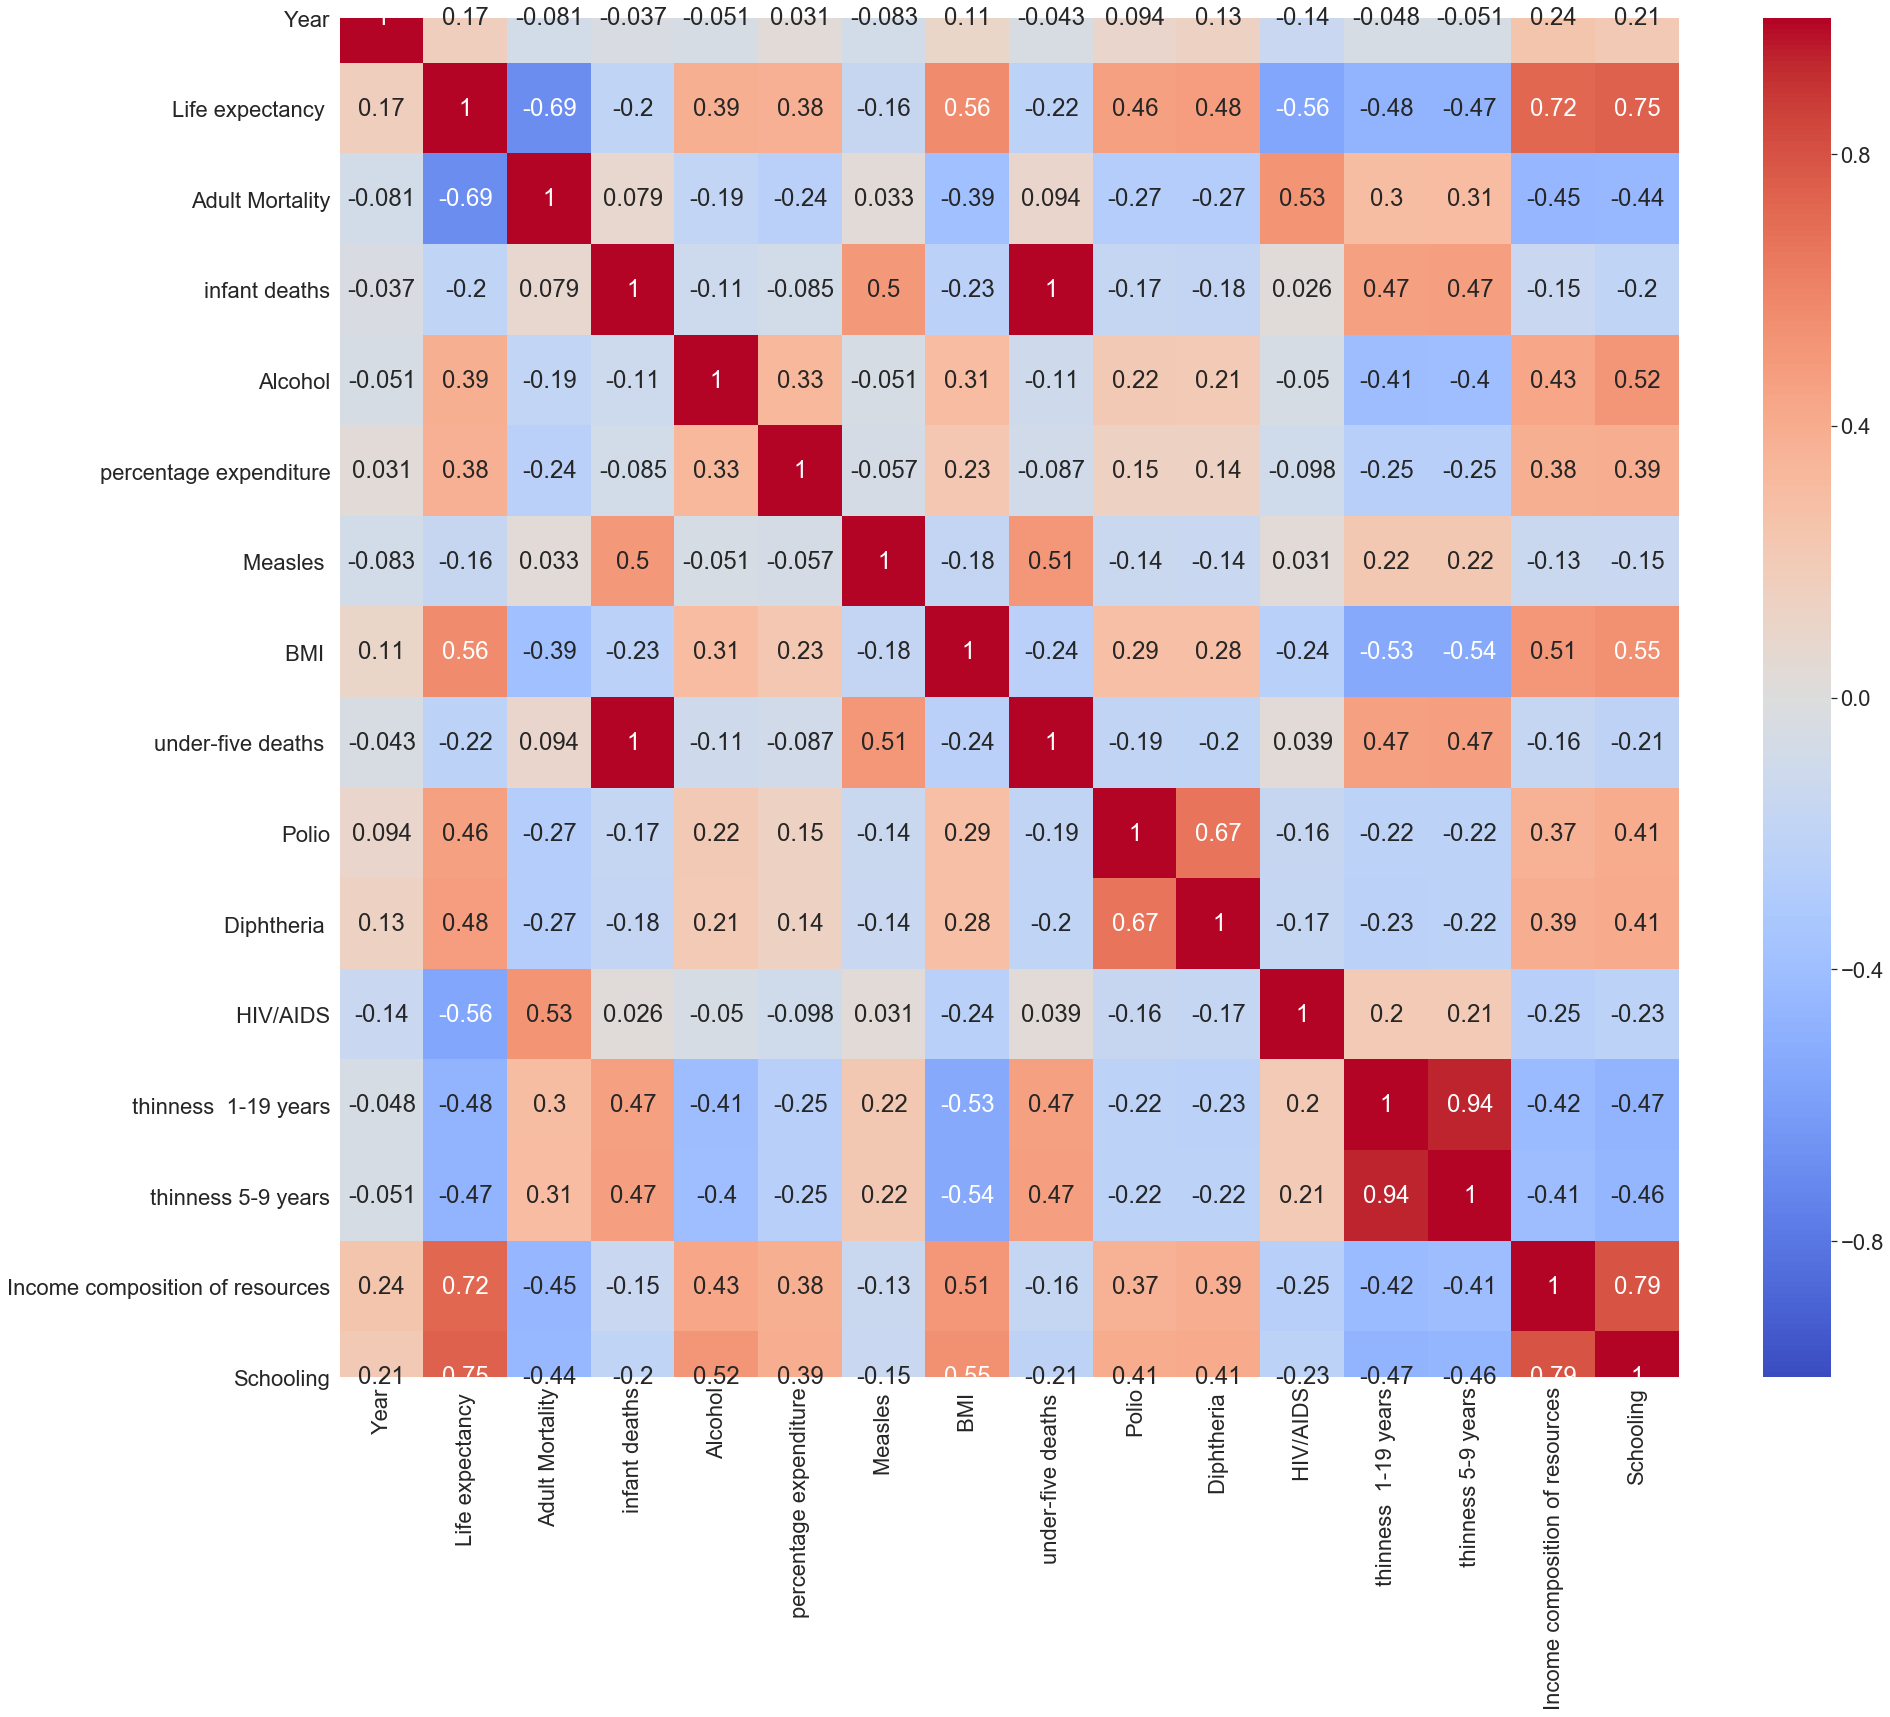

<Figure size 432x288 with 0 Axes>

In [47]:
plt.figure(figsize=(30,25))
sns.set(font_scale=2)
sns.heatmap(life_expectancy.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()
plt.clf()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1306: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 2160x1800 with 0 Axes>

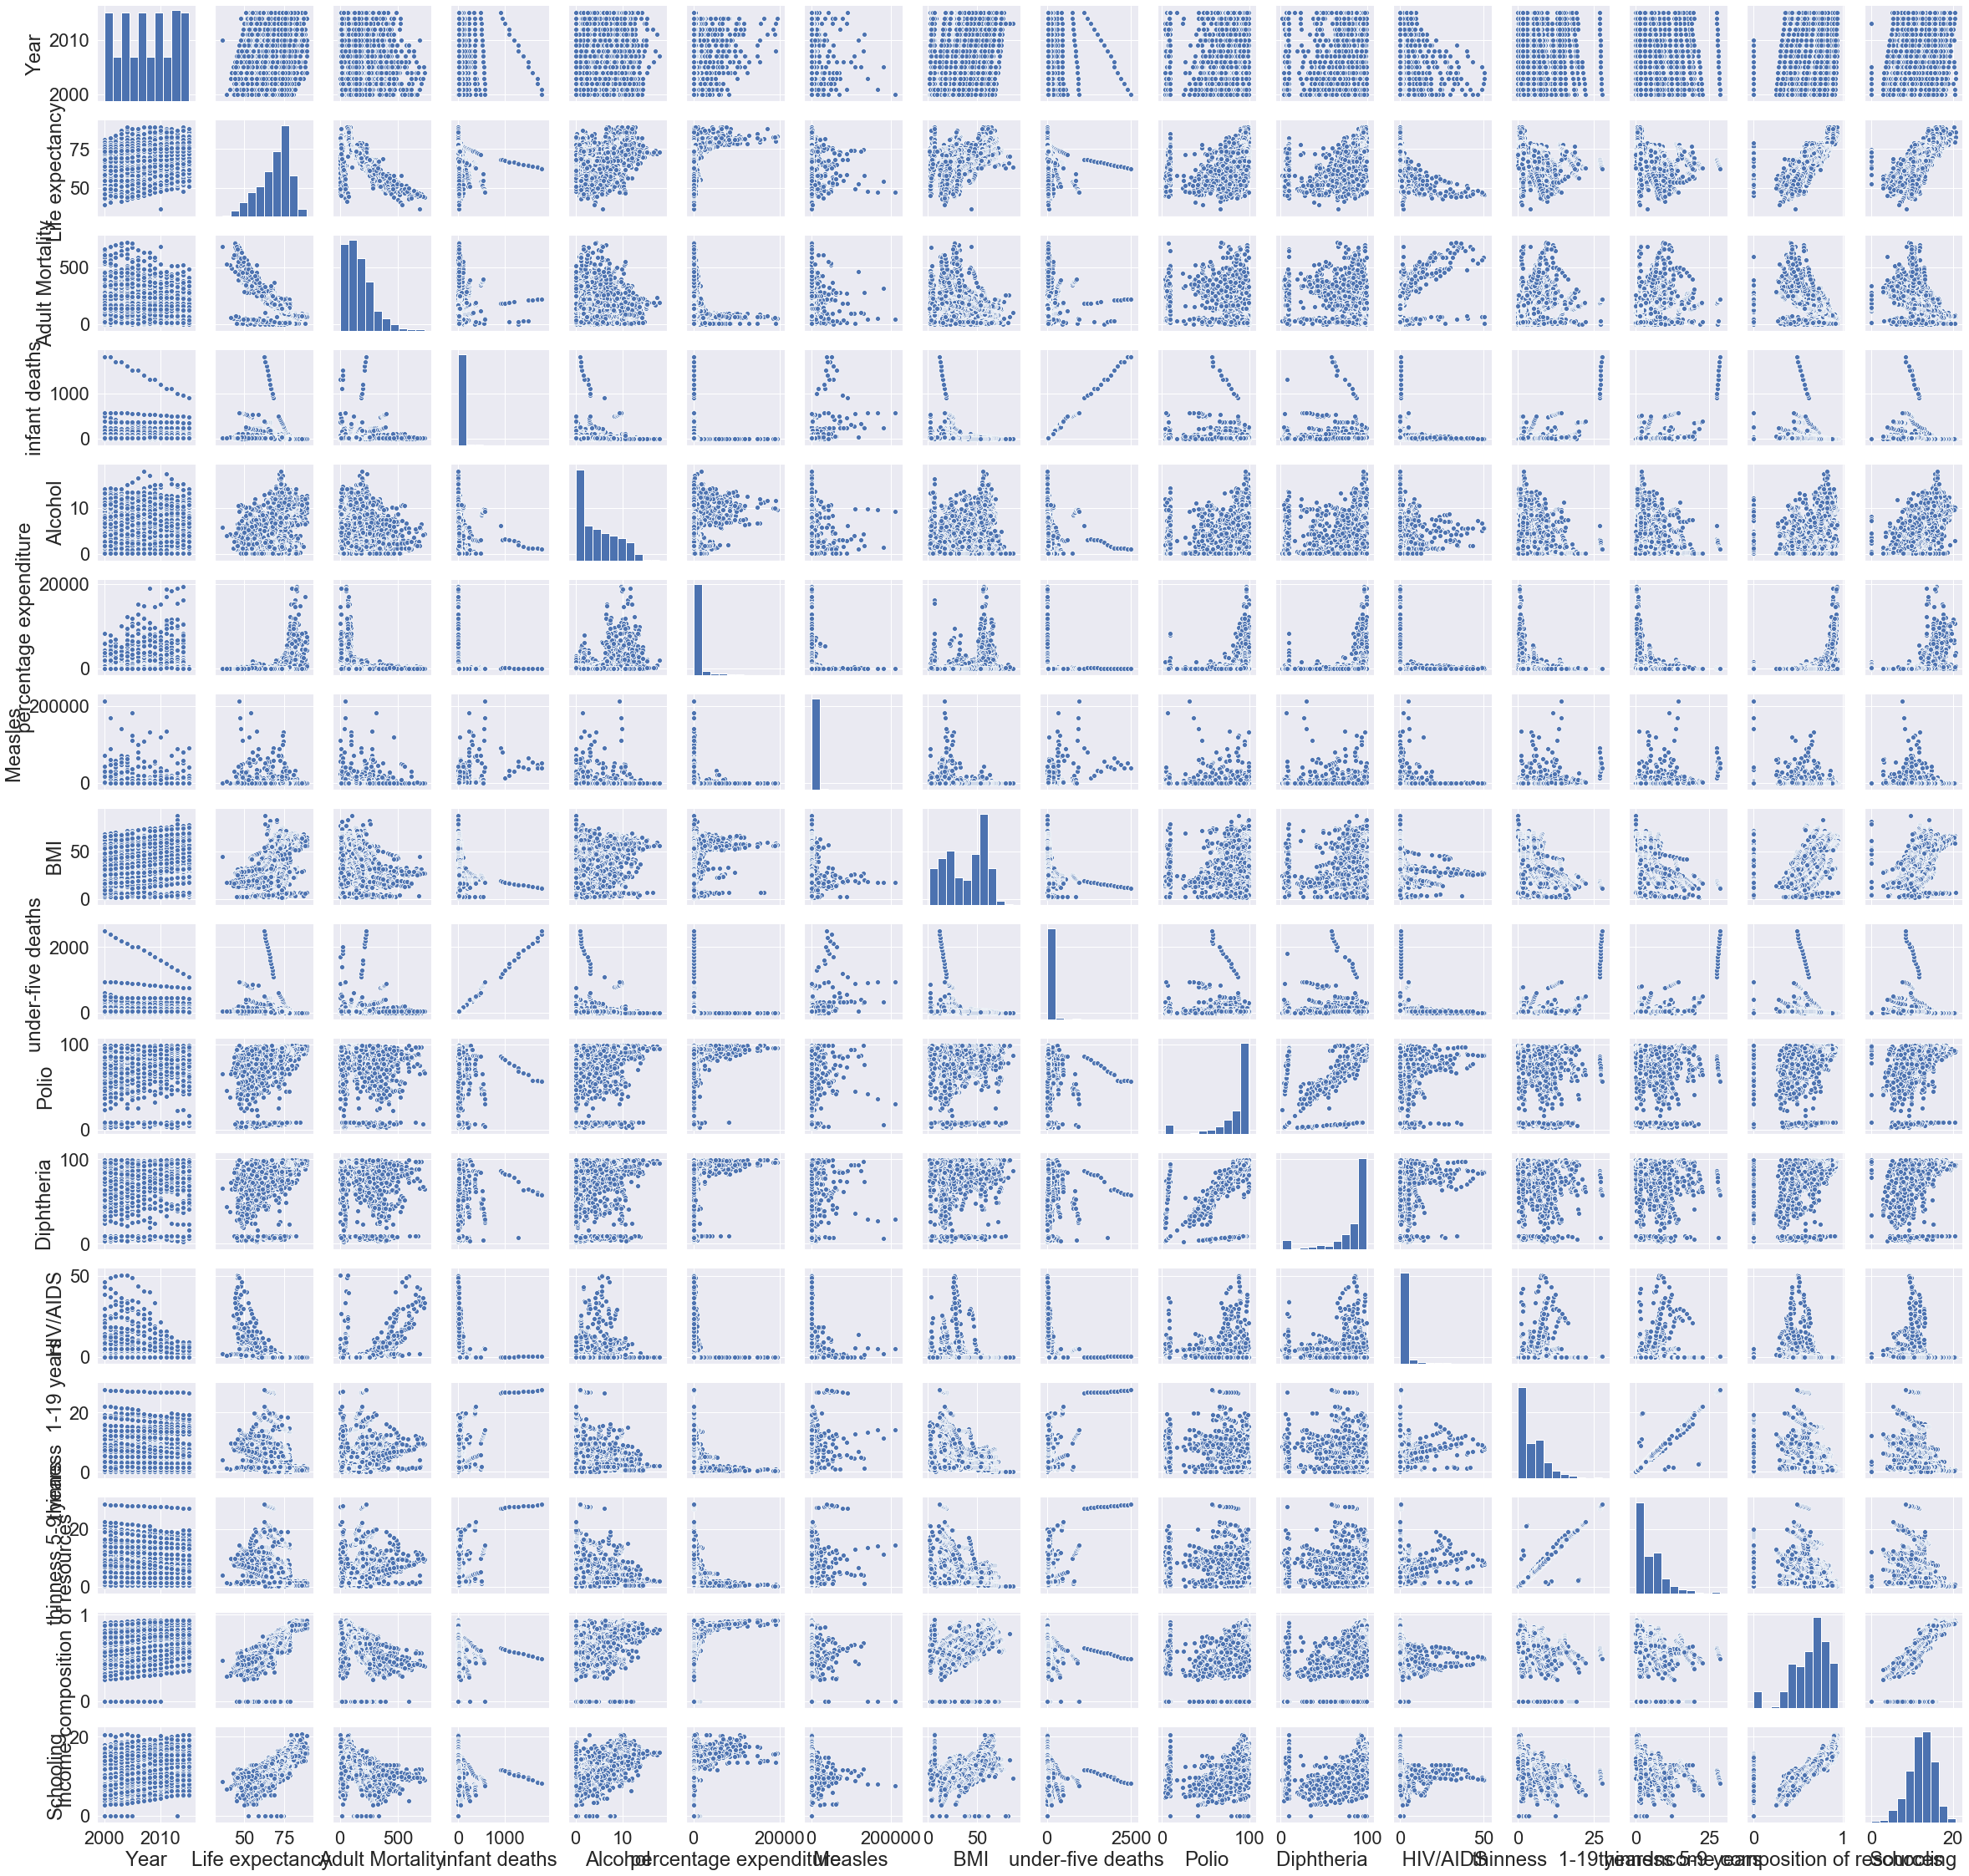

<Figure size 432x288 with 0 Axes>

In [48]:
plt.figure(figsize=(30,25))
sns.set(font_scale=2)
sns.pairplot(life_expectancy)
plt.show()
plt.clf()

## Included images of the heatmap and pairplot

<img src='IMG/14-10-Heatmap.png'></img>

<img src='IMG/14-10-Pairplot.png'></img>

From what we can see here, life expectancy has a strong negative correlation with Adult mortality (woah), and HIV. And positive correlations to BMI, Income comp, and schooling.  This would be more interesting to see split between Developing and Developed countries
